## Imports

In [1]:
from classifiers import Train_SGAN_DM_Curve, Train_SGAN_Freq_Phase, Train_SGAN_Time_Phase, Train_SGAN_Pulse_Profile
from glob import glob
import pandas as pd
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2021-08-31 13:04:44.282892: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-31 13:04:44.282918: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [1]:
base_dir = '/home/isaaccolleran/Documents/sgan/'

## Loading training and validation file data

In [2]:
from load_MWA_data import get_files_list, load_feature_datasets

path_to_data = base_dir + 'MWA_cands/'
pfd_files, pfd_labels = get_files_list(path_to_data, 'training_labels.csv')

path_to_validation = base_dir + 'MWA_validation/'
validation_files, validation_labels = get_files_list(path_to_validation, 'validation_labels.csv')

dm_curve_data, _, _, _ = load_feature_datasets(pfd_files)
validation_dm_curve_data, _, _, _ = load_feature_datasets(validation_files)

dm_curve_dataset = [dm_curve_data, pfd_labels]
dm_curve_validation_dataset = [validation_dm_curve_data, validation_labels]


In [4]:
print(len(pfd_files), len(pfd_labels), len(validation_files), len(validation_labels))
print(dm_curve_data.shape, validation_dm_curve_data.shape)

# print(np.array(dm_curve_dataset)[0].shape)
x, _ = dm_curve_dataset
print(type(x[0]), type(dm_curve_data), type(dm_curve_dataset[0]), type(x))
print(dm_curve_validation_dataset[0].shape, dm_curve_validation_dataset[1].shape)

# print(np.array(x).shape)
# print(x.shape)

# print(dm_curve_dataset[0].shape)

896 896 60 60
(896, 60, 1) (60, 60, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(60, 60, 1) (60,)


## Creating new Disciminator models and comparing their structures

In [5]:
# dm_curve_model = Train_SGAN_DM_Curve(None, None, None, None, None, None, 10)
# d_model, c_model = dm_curve_model.define_discriminator()

# print('d_model')
# print(d_model.summary())

# print('\n\nc_model')
# print(c_model.summary())

## Defining Functions
These functions will be useful for the training procedure

generate_real_samples is a function that randomly selects n_samples from the dataset. It also has the ability to apply label smoothing to the labels of the dataset

train_c_model is a function that can be called to train exclusively the supervised discriminator. It is a very specific function that will only ever needed to be called for training the c_model. All other functions, unless specified specifically, have been generalised

### Shared Functions

In [6]:
def generate_real_samples(dataset, n_samples, noisy_labels=True):
    # dataset is fed in as [x_data, labels]
    # it is also important to differentiate between labels and y values
    #    -> label = pulsar/non-pulsar
    #    -> y = real/generated
    
    # split into images and labels
    images, labels = dataset
    images = np.array(images)
    labels = np.array(labels)
    
#     print(images.shape, labels.shape)
    
    # choose random instances
    ix = np.random.randint(0, images.shape[0], n_samples)
    
    # select images and labels
    X, labels = images[ix], labels[ix]
    
    # generate class labels
    if noisy_labels:
        y = np.random.uniform(0.9, 1, (n_samples, 1))
    else:
        y = np.ones((n_samples, 1))
     
    return [X, labels], y

In [1]:
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    z_input = np.random.randn(latent_dim * n_samples)

    # reshape into a batch of inputs for the network
    z_input = z_input.reshape(n_samples, latent_dim)

    return z_input

## use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples, noisy_labels=True):
    # generate points in latent space
    z_input = generate_latent_points(latent_dim, n_samples)

    # predict outputs
    images = generator.predict(z_input)
    
    # create class labels
    if noisy_labels:
        y = np.random.uniform(0.0,0.2, (n_samples, 1))
    else:
        y = np.zeros((n_samples, 1))
    
    return images, y


In [7]:
def summarise_performance(step, c_model, validation_dataset, epoch_number, model_accuracy, save_best_model=True):
    
    validation_x, validation_y = validation_dataset
    validation_x = np.array(validation_x)
    validation_y = np.array(validation_y)
    
    _, acc = c_model.evaluate(validation_x, validation_y, verbose=0)
    
    with open('training_logs/model_performance_sgan_dm_curve.txt', 'a') as f:
        f.write('intermediate_models/dm_curve_c_model_epoch_%d.h5' % int(epoch_number) + ',' + '%.3f' % (acc) + '\n')

    if save_best_model == True:
        if acc > model_accuracy:
            print('Current Model has %.3f training accuracy which is better than previous best of %.3f. Will save it as as new best model.' % (acc * 100, model_accuracy * 100 ))
            
            filename3 = 'MWA_best_retrained_models/dm_curve_best_discriminator_model.h5'
            c_model.save(filename3)
            model_accuracy = acc
        else:
            print('Current Model is not as good as the best model. This model will not be saved. Accuracy %.3f' % (acc * 100))

        return model_accuracy, acc
    else:
        print('Classifier Accuracy: %.3f%%' % (acc * 100))

        # save the classifier model
        filename3 = 'MWA_intermediate_models/dm_curve_c_model_epoch_%d.h5' %int(epoch_number)
        c_model.save(filename3)
        print('>Saved: %s, and %s' % (filename2, filename3))
        return model_accuracy

### Whole Model Training Function

### c_model Training Function

In [32]:
def train_c_model(c_model, dataset, validation_dataset, batch_size, latent_dim=100, n_epochs=10):
    # inputs:
    #    -> c_model: the supervised discriminator model
    #    -> dataset: numpy array containing the plot data and the labels in the form [plot_data, labels]
    #    -> validation_dataset: the same as dataset except for the validation set
    #    -> batch_size: int - number of samples before back-propagation is done
    #    -> (optional) latent_dim: int - size of sample noise for generator
    #    -> (optional) n_epoch: int - number of epochs to train for with these settings
    
    n_batch = batch_size
    x, y = dataset
    
    # number of batches per training epoch
    batch_per_epoch = int(np.array(x).shape[0] / n_batch)
    
    # calculate the number of training iterations
    n_steps = batch_per_epoch * n_epochs
    
    print('n_epochs=%d, n_batch=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, batch_per_epoch, n_steps))
    
    # initial declarations before training loop
    epoch_number = 0
    model_accuracy = 0.0
    accuracies = np.zeros((n_epochs))
    
    for i in range(n_steps):
        [x_real, y_real], _ = generate_real_samples(dataset, batch_size, noisy_labels=True)
        x_real = np.reshape(x_real, (batch_size, 60, 1))
        c_loss, c_acc = c_model.train_on_batch(x_real, y_real)
        
        # print('>%d, c[loss = %.3f, accuracy = %.0f]' % (i+1, c_loss, c_acc*100))

        # if i % batch_per_epoch == 0:
        #     print(x_real.shape, y_real.shape)
        
        # evaluate the model performance every so often
        if (i+1) % (batch_per_epoch * 1) == 0:
            epoch_number += 1
            model_accuracy, this_acc = summarise_performance(i, c_model, validation_dataset, epoch_number, model_accuracy)
            accuracies[epoch_number - 1] = this_acc
            
    
    # plotting the accuracies
    plt.figure()
    plt.plot(accuracies)
    plt.xlabel('Epoch no.')
    plt.ylabel('Accuracy')
    plt.title('Batch size = {}, num epochs = {}'.format(batch_size, n_epochs))
    plt.savefig('retrain_sgan.png')


## Loading the models and their structures

Within this cell, all of the layers that aren't dense layers are changed to not trainable. We do this because we only want to update the weights of the densely connected layers.

In [61]:
dir_to_model = base_dir + 'best_retrained_models/'

# loading the models from the above
dm_curve_model = load_model(dir_to_model + 'dm_curve_best_discriminator_model.h5')
# dm_curve_model = load_model(base_dir + 'MWA_best_retrained_models/dm_curve_best_discriminator_model.h5')
time_phase_model = load_model(dir_to_model + 'time_phase_best_discriminator_model.h5')
freq_phase_model = load_model(dir_to_model + 'freq_phase_best_discriminator_model.h5')
pulse_profile_model = load_model(dir_to_model + 'pulse_profile_best_discriminator_model.h5')

# setting all layers except the dense layers to not trainable
for l in (dm_curve_model.layers + time_phase_model.layers + freq_phase_model.layers + pulse_profile_model.layers):
# for loop combines all the layers into one so that we dont need 4 separate loops
    if not l.name.startswith('dense'):
        l.trainable = False
    # print(l.name, l.trainable)

### Updating optimisers for the models

In [62]:
opt = tf.optimizers.Adam(learning_rate=0.00002, beta_1=0.99)
dm_curve_model.optimizer = opt

In [63]:
# dm_curve_model.layers[
# for l in dm_curve_model.layers:
#     print(l)

In [64]:
# print(dm_curve_model.optimizer.learning_rate)
# opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5)
# print(opt.learning_rate, opt.beta_1)

### Loading Custom Model

In [65]:
# dm_curve_model = load_model(base_dir + 'MWA_best_retrained_models/hmm_dm_curve_best_discriminator_model.h5')

## Calling Training Function

n_epochs=50, n_batch=10, b/e=41, steps=2050
Current Model is not as good as the best model. This model will not be saved. Accuracy 0.000
Current Model has 6.667 training accuracy which is better than previous best of 0.000. Will save it as as new best model.
Current Model has 66.667 training accuracy which is better than previous best of 6.667. Will save it as as new best model.
Current Model has 90.000 training accuracy which is better than previous best of 66.667. Will save it as as new best model.
Current Model has 91.667 training accuracy which is better than previous best of 90.000. Will save it as as new best model.
Current Model is not as good as the best model. This model will not be saved. Accuracy 91.667
Current Model is not as good as the best model. This model will not be saved. Accuracy 91.667
Current Model is not as good as the best model. This model will not be saved. Accuracy 88.333
Current Model is not as good as the best model. This model will not be saved. Accuracy 8

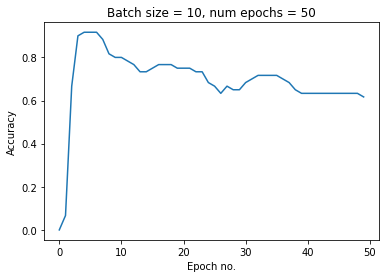

In [66]:
batch_size = 10
n_epoch = 50

train_c_model(dm_curve_model, dm_curve_dataset, dm_curve_validation_dataset, batch_size, n_epochs=n_epoch)